In [1]:
!pip install sentencepiece

In [1]:
import torch                       # PyTorch 딥러닝 프레임워크 (텐서 연산 및 모델 구축)
import torch.nn as nn              # 신경망 계층 모듈 (예: Linear, Conv, RNN, Transformer 등)
import torch.nn.functional as F    # 신경망 함수 API (예: ReLU, softmax, dropout 등 함수형 연산)

from torch.utils.data import Dataset, DataLoader  

import torch.optim as optim        # 모델 학습을 위한 최적화 알고리즘 (Adam, SGD, RMSProp 등)
import torch.optim.lr_scheduler as lr_scheduler  
# 학습률(lr) 조정 스케줄러 (훈련 epoch이나 step에 따라 lr 점진적 증가/감소)

# !pip install sentencepiece       # SentencePiece 설치 (필요 시 주석 해제 후 실행)
import sentencepiece as spm        # SentencePiece 라이브러리 (서브워드 단위 토크나이저)

import math                        # 기본 수학 함수 모듈 (지수, 로그, 제곱근 등)
import os                          # 운영체제 관련 기능 (파일 경로, 디렉토리 관리 등)
import re                          # 정규 표현식 처리 모듈 (텍스트 전처리 시 패턴 매칭/치환)
import urllib.request              # 인터넷에서 파일 다운로드/요청 처리
import zipfile                     # ZIP 압축 파일 압축/해제 모듈

import numpy as np                 # 수치 연산 라이브러리 (다차원 배열, 행렬 연산)
import pandas as pd                # 데이터 분석 라이브러리 (CSV, 엑셀 등 테이블 형태 데이터 처리)
import matplotlib.pyplot as plt    # 데이터 시각화 라이브러리 (선 그래프, 히스토그램, 시각 자료 제작)

In [2]:
# 파일 경로 (ChatbotData.csv 위치 지정)
file_path = "/home/jovyan/work//transformer_chatbot/data/ChatbotData.csv"

# CSV 파일 로드
df = pd.read_csv(file_path)  
# ChatbotData.csv 파일을 읽어와서 Pandas DataFrame으로 변환

# 데이터프레임의 상위 5개 행 출력 (컬럼 구조 및 샘플 데이터 확인)
print(df.head())

# 전체 샘플(행)의 개수 출력
print("전체 샘플 수:", len(df))

# 데이터 정제 (결측치 및 중복 제거)
df = df.dropna(subset=['Q','A'])  
# Q, A 컬럼 중 하나라도 NaN 값이 있으면 해당 행 삭제

df = df.drop_duplicates(subset=['Q','A'])  
# Q, A 내용이 동일한 중복 행 삭제 (질문+답변 쌍 단위로 고유하게 유지)

# 정제 후 데이터 크기 출력
print("정제 후 샘플 수:", len(df))

                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0
전체 샘플 수: 11823
정제 후 샘플 수: 11750


In [3]:

# 문장 전처리 함수 정의
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()  
    # 1) 모든 문장을 소문자로 변환하고 양쪽 공백 제거
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)  
    # 2) 문장부호 (?, ., !, ,) 앞뒤에 공백 추가 → 토큰화 시 분리 용이
    
    sentence = re.sub(r'[" "]+', " ", sentence)  
    # 3) 여러 개의 연속된 공백을 하나의 공백으로 치환
    
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)  
    # 4) 허용된 문자(한글, 알파벳, 숫자, 일부 문장부호) 외의 문자 제거
    
    sentence = sentence.strip()  
    # 5) 다시 양쪽 공백 제거
    
    return sentence

# 전처리 적용
df['Q'] = df['Q'].apply(preprocess_sentence)  # 질문(Q) 컬럼에 전처리 적용
df['A'] = df['A'].apply(preprocess_sentence)  # 답변(A) 컬럼에 전처리 적용

# (Q, A) 쌍 리스트 생성
pairs = list(zip(df['Q'], df['A']))  # Q, A를 튜플로 묶어 리스트로 변환

# 최종 데이터 쌍 개수 출력
print("최종 pair 수:", len(pairs))

# 샘플 5개 출력 (전처리 결과 확인용)
for i in range(5):
    print(pairs[i])

최종 pair 수: 11750
('12시 땡 !', '하루가 또 가네요 .')
('1지망 학교 떨어졌어', '위로해 드립니다 .')
('3박4일 놀러가고 싶다', '여행은 언제나 좋죠 .')
('3박4일 정도 놀러가고 싶다', '여행은 언제나 좋죠 .')
('ppl 심하네', '눈살이 찌푸려지죠 .')


In [4]:
# 말뭉치(corpus) 파일 저장
corpus_file = 'corpus.txt'
with open(corpus_file, 'w', encoding='utf-8') as f:
    for q, a in pairs:
        f.write(q + '\n')  # 질문 문장 저장
        f.write(a + '\n')  # 답변 문장 저장

# SentencePiece 모델 학습
spm.SentencePieceTrainer.Train(
    input=corpus_file,         # 학습할 말뭉치 파일
    model_prefix='spm_korean', # 저장될 모델 이름 (spm_korean.model, spm_korean.vocab 생성)
    vocab_size=8000,           # 단어 사전 크기 (BPE 병합 단위 개수)
    character_coverage=1.0,    # 문자 커버율 (1.0 → 모든 문자 사용, 0.9995 → 드문 한자 제외 등)
    model_type="bpe",          # 모델 유형 (bpe, unigram, char, word 중 선택)
    max_sentence_length=999999,# 문장 최대 길이 제한 (기본은 4192, 여기서는 매우 크게 설정)
    bos_id=1, eos_id=2, pad_id=0, unk_id=3  # 특수 토큰 ID 지정
)

# 학습된 SentencePiece 모델 로드
sp = spm.SentencePieceProcessor()
sp.Load("spm_korean.model")  # spm_korean.model 불러오기

# 토크나이저 동작 테스트
sentence = "안녕하세요. 만나서 반갑습니다!"
sentence = preprocess_sentence(sentence)  # 전처리 적용
print("전처리 후:", sentence)  

print("Tokenized:", sp.encode(sentence, out_type=str))  # 서브워드 단위로 토큰화된 문자열
print("Encoded:", sp.encode(sentence, out_type=int))    # 토큰을 ID(정수) 시퀀스로 변환
print("Decoded:", sp.decode(sp.encode(sentence)))       # 다시 문장으로 복원

전처리 후: 안녕하세요 . 만나서 반갑습니다 !
Tokenized: ['▁안녕하세요', '▁.', '▁만나서', '▁반갑', '습니다', '▁!']
Encoded: [4578, 4, 1916, 4808, 149, 112]
Decoded: 안녕하세요 . 만나서 반갑습니다 !


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: corpus.txt
  input_format: 
  model_prefix: spm_korean
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_

In [5]:
# 한국어 챗봇 데이터셋 클래스 정의
class KoreanDataset(Dataset):
    def __init__(self, pairs, sp, max_length=40):
        super().__init__()
        self.sp = sp
        self.max_length = max_length
        self.data = []

        for q_text, a_text in pairs:   # 질문(Q), 답변(A) 쌍 반복
            # 1) SentencePiece 토크나이즈 (문장을 서브워드 ID 리스트로 변환)
            q_ids = sp.EncodeAsIds(q_text)
            a_ids = sp.EncodeAsIds(a_text)

            # 2) BOS/EOS 토큰 붙이기
            bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1  # 문장 시작 토큰 (<s>)
            eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2  # 문장 종료 토큰 (</s>)

            q_tokens = [bos_id] + q_ids + [eos_id]  # 질문 시퀀스
            a_tokens = [bos_id] + a_ids + [eos_id]  # 답변 시퀀스

            # 3) 길이 제한 (max_length 초과 시 데이터 제외)
            if len(q_tokens) > max_length or len(a_tokens) > max_length:
                continue

            # 4) 패딩 (고정 길이 max_length로 맞춤, pad=0 가정)
            q_tokens += [0] * (max_length - len(q_tokens))
            a_tokens += [0] * (max_length - len(a_tokens))

            # 5) 디코더 입력/출력 분리 (Teacher Forcing)
            dec_input = a_tokens[:-1]   # 마지막 토큰 제외 (디코더 입력)
            target   = a_tokens[1:]     # 첫 토큰 제외 (디코더가 예측해야 할 라벨)

            # 6) 하나의 샘플(dict)로 저장
            self.data.append({
                "enc_input": q_tokens,  # 인코더 입력
                "dec_input": dec_input, # 디코더 입력
                "target": target        # 정답 라벨
            })

    # 데이터 개수 리턴
    def __len__(self):
        return len(self.data)

    # 인덱스로 접근 시 tensor 반환
    def __getitem__(self, idx):
        sample = self.data[idx]
        enc_input = torch.tensor(sample["enc_input"], dtype=torch.long)
        dec_input = torch.tensor(sample["dec_input"], dtype=torch.long)
        target = torch.tensor(sample["target"], dtype=torch.long)
        return enc_input, dec_input, target

# 데이터셋 생성 및 샘플 확인
dataset = KoreanDataset(pairs, sp, max_length=40)

for encoder_input, decoder_input, decoder_label in dataset:
    print("텐서 크기 :", encoder_input.size())          # 인코더 입력 텐서 크기
    print(encoder_input)                                # 인코더 입력 ID 시퀀스
    print(sp.decode(encoder_input.tolist()))            # 인코더 입력 디코딩 (문장 복원)
    print(decoder_input)                                # 디코더 입력 ID 시퀀스
    print(sp.decode(decoder_input.tolist()))            # 디코더 입력 디코딩
    print(decoder_label)                                # 정답 라벨 ID 시퀀스
    print(sp.decode(decoder_label.tolist()))            # 라벨 디코딩
    break                                               # 첫 번째 샘플만 확인

# DataLoader 생성 (배치 학습용)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 배치 하나 꺼내서 크기 확인
for encoder_input, decoder_input, decoder_label in dataloader:
    print(encoder_input.size())   # (batch_size, max_length)
    print(decoder_input.size())   # (batch_size, max_length-1)
    print(decoder_label.size())   # (batch_size, max_length-1)
    break 

텐서 크기 : torch.Size([40])
tensor([   1, 5521, 6817, 3177,  112,    2,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
12시 땡 !
tensor([   1, 4447,  213, 5885,    4,    2,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
하루가 또 가네요 .
tensor([4447,  213, 5885,    4,    2,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
하루가 또 가네요 .
torch.Size([32, 40])
torch.Size([32, 39])
torch.Size([32, 39])


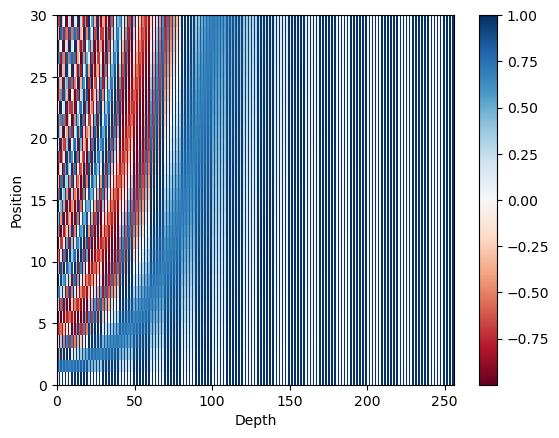

In [6]:
# 트랜스포머 위치 인코딩 (Positional Encoding)
# 기존 PositionalEncoding 클래스 (변경 없음)
class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.position = position
        self.pos_encoding = self._build_pos_encoding(position, d_model)

    def _get_angles(self, position, i, d_model):
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

    def _build_pos_encoding(self, position, d_model):
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)
        angle_rads = self._get_angles(pos, i, d_model)
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])
        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines
        pos_encoding = pos_encoding.unsqueeze(0)  # shape: [1, position, d_model]
        return pos_encoding

    def forward(self, x):
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)

# 위치 인코딩 시각화

sample_pos_encoding = PositionalEncoding(30, 256)  
# PositionalEncoding 객체 생성 (최대 시퀀스 길이=30, 임베딩 차원=256)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')  
# 위치 인코딩 행렬을 컬러맵으로 시각화 (2D 이미지 형태)
# pos_encoding.shape = [1, position, d_model] → [30, 256]

plt.xlabel('Depth')   # x축: 임베딩 차원 (d_model)
plt.xlim((0, 256))    # x축 범위: 0 ~ 256
plt.ylabel('Position')# y축: 시퀀스 내 토큰 위치 (0~29)
plt.colorbar()        # 색상 값 범례 추가
plt.show()            # 그래프 출력

In [7]:
# Scaled Dot-Product Attention
def scaled_dot_product_attention(query, key, value, mask=None):

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # query: (batch_size, heads, seq_len_q, depth)
    # key:   (batch_size, heads, seq_len_k, depth)
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len_k)
    # matmul 결과: (batch_size, heads, seq_len_q, seq_len_k)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화 (스케일링)
    # 이유: 내적 값이 커질수록 softmax 기울기 소실 방지
    depth = key.size(-1)  # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크(mask) 적용
    # 특정 위치(예: 패딩 토큰, 미래 토큰)를 -1e9로 처리 → softmax 결과 0에 가까워짐
    if mask is not None:
        # mask shape: (batch_size, 1, 1, seq_len_k) or (batch_size, 1, seq_len_q, seq_len_k)
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weight 생성
    # dim=-1: key 방향(마지막 차원)으로 정규화
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 V(Value) 내적
    # output: (batch_size, heads, seq_len_q, depth)
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

In [8]:
# 멀티 헤드 어텐션 (Multi-Head Attention)
# 기존 MultiHeadAttention 클래스 (변경 없음)
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads

        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        self.linear = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask):
        batch_size = q.size(0)
        q = self.split_heads(self.wq(q))
        k = self.split_heads(self.wk(k))
        v = self.split_heads(self.wv(v))

        scaled_attention, _ = self.scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = scaled_attention.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.linear(scaled_attention)
        return output, None

    def split_heads(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.transpose(1, 2)

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = torch.matmul(q, k.transpose(-2, -1))
        logits = matmul_qk / math.sqrt(dk)

        if mask is not None:
            logits += (mask * -1e9)

        attention_weights = F.softmax(logits, dim=-1)
        output = torch.matmul(attention_weights, v)
        return output, attention_weights

In [9]:
# 패딩 마스크 생성
def create_padding_mask(x):
    # 입력 x에서 값이 0인 위치(패딩 토큰)를 찾아 float형 1로 변환
    # 예: [1,2,0,3,0] -> [0,0,1,0,1]
    mask = (x == 0).float()

    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    # 어텐션 스코어 shape (batch, heads, seq_len_q, seq_len_k)에 브로드캐스트 되도록 변형
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask
# ===== 패딩 마스크 테스트 =====
x = torch.tensor([[1, 2, 0, 3, 0],
                  [0, 0, 0, 4, 5]])
mask = create_padding_mask(x)
print("입력 텐서 크기 :", x.shape)       # (2, 5)
print("생성된 마스크 크기 :", mask.shape) # (2, 1, 1, 5)
print(mask)

# 룩어헤드(미래 정보 차단) 마스크 생성
def create_look_ahead_mask(x):
    seq_len = x.size(1)  # 입력 시퀀스 길이

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성
    # torch.tril(torch.ones(...)) -> 하삼각은 1, 상삼각은 0
    # 1 - tril(...) -> 하삼각(자기 자신 포함)은 0, 상삼각은 1
    # 즉, 미래 토큰은 1로 마스킹 처리됨
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크도 함께 고려 (batch_size, 1, 1, seq_len)
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)  # (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)  # (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.to(x.device)  # 디바이스 맞춤 (CPU/GPU)

    # 최종 마스크: 룩어헤드와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스크 처리)
    # 최종 shape: (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

# ===== 룩어헤드 마스크 테스트 =====
x = torch.tensor([[1, 2, 3, 4, 5]])
mask_1 = create_look_ahead_mask(x)
print("첫 번째 시퀀스:\n", mask_1, mask_1.shape)

x2 = torch.tensor([[0, 5, 1, 5, 5]])
mask_2 = create_look_ahead_mask(x2)
print("두 번째 시퀀스:\n", mask_2, mask_2.shape)

입력 텐서 크기 : torch.Size([2, 5])
생성된 마스크 크기 : torch.Size([2, 1, 1, 5])
tensor([[[[0., 0., 1., 0., 1.]]],


        [[[1., 1., 1., 0., 0.]]]])
첫 번째 시퀀스:
 tensor([[[[0., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1.],
          [0., 0., 0., 1., 1.],
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])
두 번째 시퀀스:
 tensor([[[[1., 1., 1., 1., 1.],
          [1., 0., 1., 1., 1.],
          [1., 0., 0., 1., 1.],
          [1., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


In [15]:

# Transformer 인코더 레이어 (하나의 블록)
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        # (1) 멀티 헤드 어텐션 (셀프 어텐션)
        self.mha = MultiHeadAttention(d_model, num_heads)  
        self.dropout1 = nn.Dropout(dropout)                # 정규화: 과적합 방지
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)       # LayerNorm (잔차 연결 후 안정화)

        # (2) 포지션별 피드포워드 신경망 (Position-wise FFN)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # 차원 확장
            nn.ReLU(),                   # 비선형 활성화
            nn.Linear(ff_dim, d_model)   # 원래 차원으로 축소
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, mask=None):
        # (1) 멀티 헤드 셀프 어텐션
        attn_output = self.mha(x, x, x, mask)   # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)      # 잔차 연결 + 정규화

        # (2) 피드포워드 신경망
        ffn_output = self.ffn(out1)             # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)    # 잔차 연결 + 정규화

        return out2

# Transformer 인코더 전체 (여러 블록 쌓기)
class Encoder(nn.Module):
    def __init__(self,
                 vocab_size,   # 단어 사전 크기
                 num_layers,   # 인코더 레이어 개수
                 ff_dim,       # 피드포워드 내부 차원
                 d_model,      # 임베딩 차원
                 num_heads,    # 어텐션 head 개수
                 dropout=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어 (단어 ID → 벡터)
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩 (위치 정보 추가)
        # position=vocab_size 로 설정했는데 보통은 max_seq_len을 넣는 경우가 많음
        self.pos_encoding = PositionalEncoding(position=MAX_LEN, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) EncoderLayer 여러 개 쌓기 (num_layers 만큼 반복)
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        # (1) 입력 단어를 임베딩 + √d_model 로 스케일링
        # (논문에서: 큰 값 방지 및 안정적 학습을 위함)
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 더하기 + 드롭아웃
        x = self.pos_encoding(x)   # (batch_size, seq_len, d_model)
        x = self.dropout(x)

        # (3) 여러 개의 인코더 레이어를 순차적으로 통과
        for layer in self.enc_layers:
            x = layer(x, mask)

        return x   # (batch_size, seq_len, d_model)

# 기존 PointWiseFeedForwardNetwork 클래스 (변경 없음)
class PointWiseFeedForwardNetwork(nn.Module):
    def __init__(self, d_model, dff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, dff)
        self.linear2 = nn.Linear(dff, d_model)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [16]:
# Transformer 디코더 레이어 
# 수정: Transformer 클래스에서 인코더 제거, 디코더만 사용
class Transformer(nn.Module):  # 클래스 이름 유지
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, pe_maxlen, rate=0.1):
        super().__init__()
        self.d_model = d_model
        # 변경: 인코더 임베딩 제거, 디코더 임베딩만 사용
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(pe_maxlen, d_model)
        # 변경: 인코더 레이어 제거, 디코더 레이어만 유지
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)])
        self.dropout = nn.Dropout(rate)
        self.final_layer = nn.Linear(d_model, vocab_size)
        # 추가: 패딩 마스크를 위한 패딩 토큰 ID 저장
        self.padding_idx = None  # 초기화 시 ChatbotDataset에서 설정

    def forward(self, x):  # 변경: enc_input 제거, x만 입력
        # 변경: enc_input 제거, x(디코더 입력)만 처리
        # 추가: 룩어헤드 마스크와 패딩 마스크 생성 및 결합
        look_ahead_mask = self.create_look_ahead_mask(x.size(1)).to(x.device)
        padding_mask = self.create_padding_mask(x).to(x.device)
        mask = torch.maximum(look_ahead_mask, padding_mask)  # 두 마스크 결합
        # 변경: 인코더 처리 제거, 디코더 입력만 임베딩
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        # 변경: 디코더 레이어만 반복, enc_output 제거
        for layer in self.decoder_layers:
            x = layer(x, mask)  # mask는 룩어헤드 + 패딩 마스크
        x = self.final_layer(x)
        return x

    # 추가: look-ahead 마스크 생성 함수
    def create_look_ahead_mask(self, size):
        mask = torch.triu(torch.ones(size, size), diagonal=1)
        return mask
    # 추가: 패딩 마스크 생성 (패딩 토큰의 어텐션 차단)
    def create_padding_mask(self, seq):
        mask = (seq == self.padding_idx).float()
        mask = mask.unsqueeze(1).unsqueeze(2)
        return mask
    
# 수정: DecoderLayer에서 크로스 어텐션(mha2) 제거
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()
        # 변경: 셀프 어텐션(mha1)만 유지, 크로스 어텐션(mha2) 제거
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.ffn = PointWiseFeedForwardNetwork(d_model, dff)
        self.layernorm1 = nn.LayerNorm(d_model)
        # 변경: 크로스 어텐션 관련 layernorm2 제거, ffn용 layernorm2만 유지
        self.layernorm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)

    def forward(self, x, mask):
        # 변경: enc_output(out2) 제거, 셀프 어텐션만 수행
        # 주석: x를 쿼리, 키, 값으로 사용하여 out2 대체
        attn1, _ = self.mha1(x, x, x, mask)  # 기존: mha2에서 enc_output 사용
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(x + attn1)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)  # 기존: out2는 인코더 출력이었으나, 여기서는 최종 출력
        return out2
    
# 수정: ChatbotDataset에서 질문과 답변 결합
class ChatbotDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=40):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.START_TOKEN = tokenizer.bos_id()
        self.END_TOKEN = tokenizer.eos_id()
        self.PAD_TOKEN = tokenizer.pad_id()
        self.data = []
        for q, a in zip(data['Q'], data['A']):
            q = preprocess_sentence(q)
            a = preprocess_sentence(a)
            # 변경: 질문(Q)과 답변(A)을 "Q: {q} A: {a}"로 결합하여 단일 시퀀스 처리
            combined = f"Q: {q} A: {a}"
            tokens = [self.START_TOKEN] + tokenizer.encode(combined) + [self.END_TOKEN]
            pad_len = max_len - len(tokens)
            if pad_len > 0:
                tokens += [self.PAD_TOKEN] * pad_len
            else:
                tokens = tokens[:max_len]
            self.data.append(tokens)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.long)


In [17]:
# 예시: 하이퍼파라미터 설정
# 수정: 모델 초기화 (인코더 입력 제거, 패딩 토큰 ID 설정)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = sp.GetPieceSize()
model = Transformer(
    num_layers=2,
    d_model=256,
    num_heads=8,
    dff=512,
    vocab_size=vocab_size,
    pe_maxlen=40
).to(device)
# 추가: 패딩 마스크를 위해 패딩 토큰 ID 설정
model.padding_idx = sp.pad_id()
print(f'Using device: {device}')

print(model)  # Transformer 전체 아키텍처 요약 출력

Using device: cuda
Transformer(
  (embedding): Embedding(8000, 256)
  (pos_encoding): PositionalEncoding()
  (decoder_layers): ModuleList(
    (0-1): 2 x DecoderLayer(
      (mha1): MultiHeadAttention(
        (wq): Linear(in_features=256, out_features=256, bias=True)
        (wk): Linear(in_features=256, out_features=256, bias=True)
        (wv): Linear(in_features=256, out_features=256, bias=True)
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (ffn): PointWiseFeedForwardNetwork(
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
      )
      (layernorm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (layernorm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (final_layer): Linear(in_

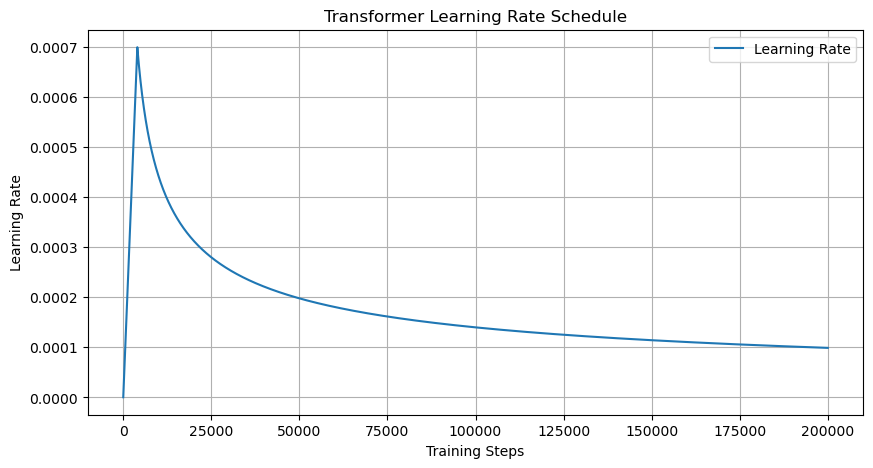

In [18]:
# 손실 함수 정의
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())
# 학습률 스케줄러 함수 
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1
        # 공식: (d_model^(-0.5)) * min(step^(-0.5), step * warmup_steps^(-1.5))
        # - 초기에는 step * warmup_steps^(-1.5) → 학습률 증가(warmup)
        # - 이후에는 step^(-0.5) → 학습률 감소
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda
# 하이퍼파라미터 설정
d_model = 512          # 임베딩 차원
warmup_steps = 4000    # 워밍업 단계 수
total_steps = 200000   # 전체 학습 스텝 수

# 학습률 스케줄 계산
steps = np.arange(1, total_steps + 1)  # 1 ~ total_steps
learning_rates = [get_lr_lambda(d_model, warmup_steps)(step) for step in steps]

# 학습률 변화 시각화
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Transformer Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# Optimizer 정의 (Adam)
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9, lr=1.0)
# Scheduler 정의 (LambdaLR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# 정확도 계산 함수
def accuracy_function(y_pred, y_true, pad_id=0):
    preds = y_pred.argmax(dim=-1)  # 가장 확률 높은 단어 선택 (batch_size, seq_len)
    # pad 토큰은 정확도 계산에서 제외
    mask = (y_true != pad_id)
    # 예측과 정답이 일치하면서 pad가 아닌 경우만 correct로 계산
    correct = (preds == y_true) & mask
    # 정확도 = (맞춘 개수 / 실제 pad가 아닌 단어 개수)
    acc = correct.float().sum() / mask.float().sum()
    return acc
# Device 설정 (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 모델을 해당 디바이스로 이동
model = model.to(device)


In [20]:
# 수정: 학습 함수 (인코더 입력 제거)
def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        total_acc = 0
        steps = 0
        for batch in dataloader:
            question_tensor, answer_tensor, target_tensor = batch
    
            # 이제 각 텐서를 개별적으로 디바이스에 올릴 수 있습니다.
            question_tensor = question_tensor.to(device)
            answer_tensor = answer_tensor.to(device)
            target_tensor = target_tensor.to(device)
            
            # 타겟은 답변 텐서에서 첫 토큰을 제외
            targets = answer_tensor[:, 1:]
            # batch = batch.to(device)
            # batch = [item.to(device) for item in batch]    # 리스트의 각 요소를 텐서로 변환하고 디바이스로 이동
            batch = torch.stack(batch).to(device)
            # 변경: enc_input 제거, 디코더 입력만 처리
            inputs = batch[:, :-1]  # 입력: 마지막 토큰 제외
            targets = batch[:, 1:]  # 타겟: 첫 토큰 제외
            optimizer.zero_grad()
            # 변경: enc_input 제거, inputs만 모델에 전달
            outputs = model(inputs)
            loss = loss_function(outputs.view(-1, vocab_size), targets.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            predicted = torch.argmax(outputs, dim=-1)
            acc = (predicted == targets).float().mean()
            total_acc = acc.item()
            steps += 1
        avg_loss = total_loss / steps
        avg_acc = total_acc / steps
        print(f"[Epoch {epoch+1}] Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")
import torch.optim as optim


In [21]:
%%time
train(model, dataloader, optimizer, loss_function, scheduler, num_epochs=25, device=device)

RuntimeError: stack expects each tensor to be equal size, but got [32, 40] at entry 0 and [32, 39] at entry 1

In [ ]:
프로세스의 전체적인 흐름을 제대로 이해하지 못하고 하려고 했더니 잘 안됐다.
다양한 시도를 해봤지만 끝내 코드를 완성하지 못했다.
ㅠㅜ 